In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import numpy as np
import random

In [2]:
class Config:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers = 2
    dataset_path = '/kaggle/input/dgm-animals/Animals_data/animals/animals'
    image_size = 128
    img_channels = 3
    latent_dim = 100
    embedding_dim = 100
    features_g = 64
    features_d = 64
    batch_size = 64
    num_epochs = 100
    lr = 0.0002
    beta1 = 0.5
    beta2 = 0.999
    label_smoothing = 0.1
    output_dir = '/kaggle/working/Q6_cGAN_20_classes_G_heavy'
    num_classes_subset = 20
    
    # training ratio
    d_updates_per_step = 1
    g_updates_per_step = 7

config = Config()
os.makedirs(config.output_dir, exist_ok=True)
print(f"Configuration loaded. D:G Ratio = {config.d_updates_per_step}:{config.g_updates_per_step}")

Configuration loaded. D:G Ratio = 1:7


In [3]:
full_dataset_for_inspection = datasets.ImageFolder(root=config.dataset_path)
all_class_names = full_dataset_for_inspection.classes
selected_class_names = sorted(random.sample(all_class_names, config.num_classes_subset))
print(f"\nTraining on {config.num_classes_subset} randomly selected classes.")


Training on 20 randomly selected classes.


In [4]:
class ClassSubsetDataset(Dataset):
    def __init__(self, subset, class_mapping):
        self.subset = subset
        self.class_mapping = class_mapping
    def __getitem__(self, index):
        image, original_label_idx = self.subset[index]
        new_label_idx = self.class_mapping[original_label_idx]
        return image, new_label_idx
    def __len__(self):
        return len(self.subset)

transform = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
full_dataset = datasets.ImageFolder(root=config.dataset_path, transform=transform)

selected_class_indices = [full_dataset.class_to_idx[name] for name in selected_class_names]
class_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(selected_class_indices)}
subset_indices = [i for i, (_, label_idx) in enumerate(full_dataset.samples) if label_idx in selected_class_indices]
subset = Subset(full_dataset, subset_indices)
train_dataset_20_classes = ClassSubsetDataset(subset, class_mapping)
dataloader = DataLoader(train_dataset_20_classes, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)

print(f"\nFiltered dataset created with {len(train_dataset_20_classes)} images.")


Filtered dataset created with 1193 images.


In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1: nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1: nn.init.normal_(m.weight.data, 1.0, 0.02); nn.init.constant_(m.bias.data, 0)
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, embedding_dim, channels_img, features_g):
        super(ConditionalGenerator, self).__init__(); self.embed = nn.Embedding(num_classes, embedding_dim)
        self.net = nn.Sequential(
            self._block(latent_dim+embedding_dim, features_g*16, 4, 1, 0), self._block(features_g*16, features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g*4, 4, 2, 1), self._block(features_g*4, features_g*2, 4, 2, 1),
            self._block(features_g*2, features_g, 4, 2, 1), nn.ConvTranspose2d(features_g, channels_img, 4, 2, 1), nn.Tanh())
    def _block(self, i, o, k, s, p): return nn.Sequential(nn.ConvTranspose2d(i, o, k, s, p, bias=False), nn.BatchNorm2d(o), nn.ReLU(True))
    def forward(self, z, l): return self.net(torch.cat([z, self.embed(l).unsqueeze(2).unsqueeze(3)], 1))
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, embedding_dim, channels_img, features_d):
        super(ConditionalDiscriminator, self).__init__(); self.embed = nn.Embedding(num_classes, embedding_dim)
        self.net = nn.Sequential(
            nn.Conv2d(channels_img+embedding_dim, features_d, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            self._block(features_d, features_d*2, 4, 2, 1), self._block(features_d*2, features_d*4, 4, 2, 1),
            self._block(features_d*4, features_d*8, 4, 2, 1), self._block(features_d*8, features_d*16, 4, 2, 1),
            nn.Conv2d(features_d*16, 1, 4, 1, 0), nn.Sigmoid())
    def _block(self, i, o, k, s, p): return nn.Sequential(nn.Conv2d(i, o, k, s, p, bias=False), nn.BatchNorm2d(o), nn.LeakyReLU(0.2, True), nn.Dropout(0.3))
    def forward(self, x, l):
        emb = self.embed(l).view(l.shape[0], -1, 1, 1).expand(-1, -1, x.shape[2], x.shape[3])
        return self.net(torch.cat([x, emb], 1)).view(-1, 1).squeeze(1)

In [6]:
gen = ConditionalGenerator(config.latent_dim, config.num_classes_subset, config.embedding_dim, config.img_channels, config.features_g).to(config.device)
disc = ConditionalDiscriminator(config.num_classes_subset, config.embedding_dim, config.img_channels, config.features_d).to(config.device)
gen.apply(weights_init); disc.apply(weights_init)

criterion = nn.BCELoss()
optimizerD = optim.Adam(disc.parameters(), lr=config.lr, betas=(config.beta1, config.beta2))
optimizerG = optim.Adam(gen.parameters(), lr=config.lr, betas=(config.beta1, config.beta2))

In [7]:
G_losses, D_losses = [], []
print("\nStarting training on 20-class subset...")
for epoch in range(config.num_epochs):
    epoch_loss_d, epoch_loss_g = 0.0, 0.0
    for i, (real_imgs, labels) in enumerate(dataloader):
        real_imgs, labels = real_imgs.to(config.device), labels.to(config.device)
        b_size = real_imgs.size(0)
        real_label = torch.full((b_size,), 1.0 - config.label_smoothing, device=config.device)
        fake_label = torch.full((b_size,), 0.0, device=config.device)
        
        # Train Discriminator 'd_updates' times
        for _ in range(config.d_updates_per_step):
            disc.zero_grad()
            with torch.no_grad():
                noise = torch.randn(b_size, config.latent_dim, 1, 1, device=config.device)
                fake_imgs = gen(noise, labels)
            
            output_real = disc(real_imgs, labels)
            lossD_real = criterion(output_real, real_label)
            output_fake = disc(fake_imgs.detach(), labels)
            lossD_fake = criterion(output_fake, fake_label)
            lossD = (lossD_real + lossD_fake) / 2
            lossD.backward(); optimizerD.step()
            epoch_loss_d += lossD.item()

        # Train Generator 'g_updates' times
        for _ in range(config.g_updates_per_step):
            gen.zero_grad()
            noise = torch.randn(b_size, config.latent_dim, 1, 1, device=config.device)
            fake_imgs = gen(noise, labels)
            output_gen = disc(fake_imgs, labels)
            lossG = criterion(output_gen, real_label)
            lossG.backward(); optimizerG.step()
            epoch_loss_g += lossG.item()

    avg_loss_d = epoch_loss_d / (len(dataloader) * config.d_updates_per_step)
    avg_loss_g = epoch_loss_g / (len(dataloader) * config.g_updates_per_step)
    G_losses.append(avg_loss_g)
    D_losses.append(avg_loss_d)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"[Epoch {epoch+1}/{config.num_epochs}] Avg Loss_D: {avg_loss_d:.4f} | Avg Loss_G: {avg_loss_g:.4f}")



Starting training on 20-class subset...
[Epoch 1/100] Avg Loss_D: 1.5690 | Avg Loss_G: 0.9821
[Epoch 10/100] Avg Loss_D: 0.8627 | Avg Loss_G: 0.9234
[Epoch 20/100] Avg Loss_D: 0.8060 | Avg Loss_G: 0.9121
[Epoch 30/100] Avg Loss_D: 0.7799 | Avg Loss_G: 0.8765
[Epoch 40/100] Avg Loss_D: 0.7865 | Avg Loss_G: 0.9054
[Epoch 50/100] Avg Loss_D: 0.7632 | Avg Loss_G: 0.8574
[Epoch 60/100] Avg Loss_D: 0.7453 | Avg Loss_G: 0.8694
[Epoch 70/100] Avg Loss_D: 0.7337 | Avg Loss_G: 0.8422
[Epoch 80/100] Avg Loss_D: 0.7519 | Avg Loss_G: 0.8488
[Epoch 90/100] Avg Loss_D: 0.7367 | Avg Loss_G: 0.8341
[Epoch 100/100] Avg Loss_D: 0.7535 | Avg Loss_G: 0.8374


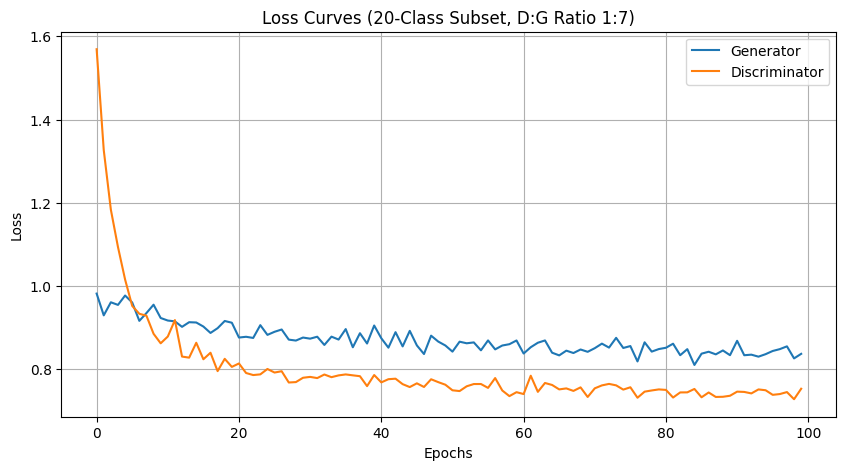

In [8]:
torch.save(gen.state_dict(), os.path.join(config.output_dir, 'generator_20_class.pth'))
torch.save(disc.state_dict(), os.path.join(config.output_dir, 'discriminator_20_class.pth'))
np.save(os.path.join(config.output_dir, 'selected_class_names.npy'), np.array(selected_class_names))
torch.save(class_mapping, os.path.join(config.output_dir, 'class_mapping.pth'))

plt.figure(figsize=(10, 5))
plt.title("Loss Curves (20-Class Subset, D:G Ratio 1:7)")
plt.plot(G_losses, label="Generator"); plt.plot(D_losses, label="Discriminator")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
plt.savefig(os.path.join(config.output_dir, "loss_curve_20_class.png"))
plt.show()